<a href="https://colab.research.google.com/github/SashaSBonacina/PET-Alzheimer-Prediction-Thesis/blob/main/BAE_16_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

## Importing libraries

In [136]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2, re, itertools,pathlib
from skimage import transform
import scipy.ndimage as ndi
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf


## Mounting google drive to access the data

In [137]:
drive.mount('/content/drive') #mounting drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading in CSV with Image ID, Age, Sex

In [138]:
cols = ['Image Data ID', 'Subject', 'Group', 'Sex', 'Age', 'Visit',
       'Description', 'Type', 'Acq Date'] # we dont need all the columns
df = pd.read_csv('/content/drive/MyDrive/CN FOR BAE DATA/Tx_Origin_SpatNORM_CN.csv', usecols = cols)
df.columns = ['ID', 'Subject', 'Group', 'Sex', 'Age', 'Visit',
       'Descrip', 'Type', 'Acq Date'] # renaming cols


In [139]:
df.head()

,ID,Subject,Group,Sex,Age,Visit,Descrip,Type,Acq Date
0,I387827,024_S_4084,CN,F,71,v21,[F-18]AV-45 Dy2 4i/16s AV45,Original,8/27/2013
1,I388229,024_S_4158,CN,M,86,v21,[F-18]AV-45 Dy2 4i/16s AV45,Original,8/30/2013
2,I509380,024_S_4158,CN,M,88,v41,[F-18]AV-45 Dy1 4i/16s AV45,Original,9/03/2015
3,I388228,024_S_4158,CN,M,86,v21,[F-18]AV-45 Dy1 4i/1 Early AV45,Original,8/30/2013
4,I387826,024_S_4084,CN,F,71,v21,[F-18]AV-45 Dy1 4i/1 Early AV45,Original,8/27/2013


Collecting file paths with the images

In [140]:
directory = '/content/drive/MyDrive/CN FOR BAE DATA/Tx_Origin_SpatNORM_CN_imageID' # enter the dir were the images are stored
image_ids = []
for filename in os.listdir(directory):
  image_ids.append(filename)
print(len(image_ids))

102


In [141]:
df = df[df['ID'].isin(image_ids)] #filterring the df so it only contains the data we need
df = df.reset_index()

In [142]:
df.shape

(102, 10)

Adding the image paths to the df for the corresponding image ID

In [143]:
# new colunm for the paths
df['Loc'] = ''
# iterate over files in that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    image_id_folder = filename

    for image in os.listdir(f):
      f = os.path.join(f, image)
      if os.path.isfile(f) and f.endswith('nii'):  # checking if it is a file and a .nii file
          df.loc[df['ID']==image_id_folder, 'Loc' ] = f # appending the path

In [144]:
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'M' else -1)

# Data Information (vis)

## Bar graphs

In [ ]:
df['Shape'] = df['Loc'].apply(lambda x: nib.load(x).get_fdata().shape) # adding the shape of each image as a feature
df['Type'] = df['Loc'].apply(lambda x: type(nib.load(x))) # adding the type of each image as a feature

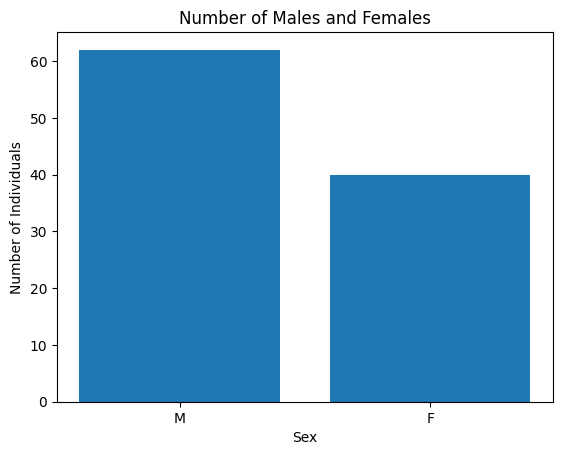

In [ ]:
sex_counts = df["Sex"].value_counts()
# Plot the bar chart
plt.bar(sex_counts.index, sex_counts.values)
plt.xlabel("Sex")
plt.ylabel("Number of Individuals")
plt.title("Number of Males and Females")
plt.show()

Text(0.5, 1.0, 'Age Distribution')

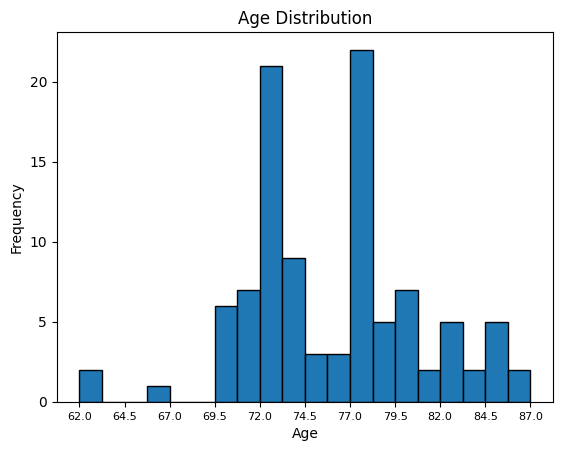

In [ ]:
plt.hist(df["Age"], bins=20, edgecolor="black")
plt.xlabel("Age")
plt.ylabel("Frequency")
num_ticks = 11  # The number of ticks you want
x_ticks = np.linspace(df["Age"].min(), df["Age"].max(), num_ticks)
plt.xticks(x_ticks, fontsize=8)

plt.title("Age Distribution")

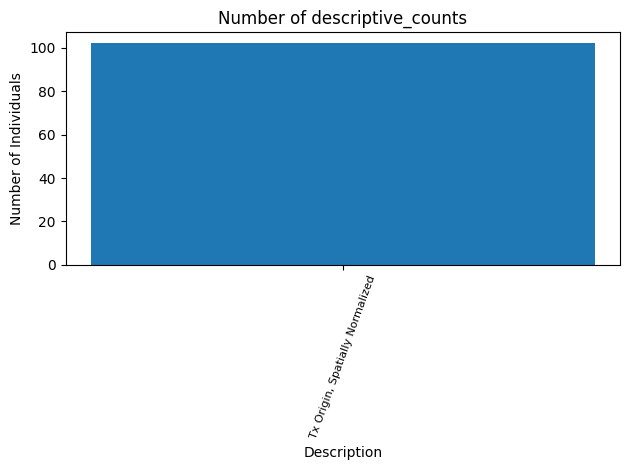

In [ ]:
descriptive_counts = df["Descrip"].value_counts()
# Plot the bar chart
plt.bar(descriptive_counts.index, descriptive_counts.values)
plt.xlabel("Description")
plt.ylabel("Number of Individuals")
plt.title("Number of descriptive_counts")
plt.xticks(fontsize=8, rotation=70)
plt.tight_layout()
plt.show()

In [ ]:
len(df['Subject'].unique())

102

Each subject has only 1 image in the df

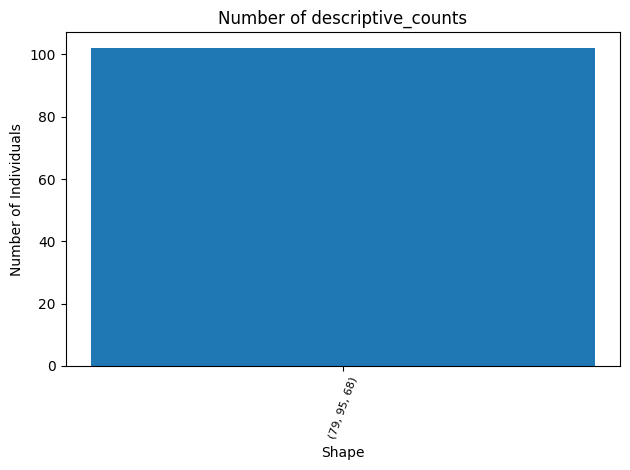

In [ ]:
descriptive_counts = df["Shape"].astype(str).value_counts()

# Plot the bar chart
plt.bar(descriptive_counts.index, descriptive_counts.values)
plt.xlabel("Shape")
plt.ylabel("Number of Individuals")
plt.title("Number of descriptive_counts")
plt.xticks(fontsize=8, rotation=70)
plt.tight_layout()
plt.show()

No reshaping needed as all are the same shape! This is because the same processing steps were taken by ADNI for each image.

Furthermore each image is 3d not 4d, so t has been average through the image in processing

## Looking at one image

In [169]:
x = list(df['Loc'])[11] # getting a random image path
brain_vol = nib.load(x)
# What is the type of this object?
type(brain_vol)

nibabel.nifti1.Nifti1Image

In [170]:
brain_vol_data = brain_vol.get_fdata()
type(brain_vol_data)

numpy.memmap

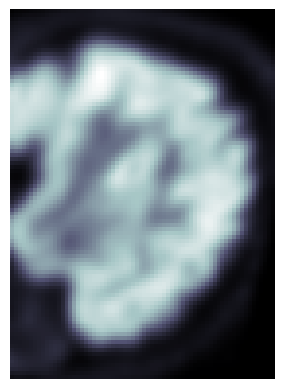

In [171]:
plt.imshow(brain_vol_data[60], cmap='bone')
plt.axis('off')
plt.show()

# Building some models!

## 3D model

### preparing the data

In [145]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
import keras
from keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



Extracting data in the correct format for the model

In [146]:
# Extract image data and corresponding ages from the DataFrame
image_paths = df['Loc'].values
ages = df['Age'].values
sexes = df['Sex'].values

# Initialize empty lists to store image arrays and labels
image_data = []
labels = []

# Loop through each image path, load the image, and append to the lists
for path, age in zip(image_paths, ages):
    image = nib.load(path).get_fdata()
    image_data.append(image)
    labels.append(age)

# Convert lists to numpy arrays
image_data = np.array(image_data)
labels = np.array(labels)

# Reshape the image data to match the CNN input shape (128, 128, 82, 6) -> (samples, 128, 128, 82, 6)
image_data = image_data.reshape(-1, 79, 95, 68, 1)



In [147]:
count = 0
locations = []
shape = image_data.shape
for a in range(shape[0]):
  for b in range(shape[1]):
    for c in range(shape[2]):
      for d in range(shape[3]):
        if pd.isna(image_data[a][b][c][d]):
          locations.append([a,b,c,d])
          count+=1
print(count)

9677


In [159]:
from collections import Counter
Counter([ele[0] for ele in locations])

Counter({10: 5392, 60: 4285})

In [173]:
5392/(79*95*68)

0.010565505349374926

images 10 and 60 have some nans, as this is only 1% of the image we can replace the pixels with averages

In [180]:
x = list(df['Loc'])[10] # getting a random image path
brain_vol = nib.load(x)
# What is the type of this object?
type(brain_vol)

nibabel.nifti1.Nifti1Image

In [181]:
brain_vol_data = brain_vol.get_fdata()
type(brain_vol_data)

numpy.memmap

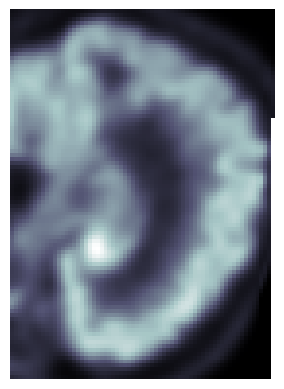

In [182]:
plt.imshow(brain_vol_data[50], cmap='bone')
plt.axis('off')
plt.show()

we can see the nans on the right hand side of the image

In [183]:
for location in locations:
  surrounding_pixels = []
  try:
    surrounding_pixels.append(image_data[location[0]][location[1]-1][location[2]][location[3]])
  except:
    None
  try:
    surrounding_pixels.append(image_data[location[0]][location[1]+1][location[2]][location[3]])
  except:
    None
  try:
    surrounding_pixels.append(image_data[location[0]][location[1]][location[2]-1][location[3]])
  except:
    None
  try:
    surrounding_pixels.append(image_data[location[0]][location[1]][location[2]+1][location[3]])
  except:
    None
  try:
    surrounding_pixels.append(image_data[location[0]][location[1]][location[2]][location[3]-1])
  except:
    None
  try:
    surrounding_pixels.append(image_data[location[0]][location[1]][location[2]][location[3]+1])
  except:
    None
  image_data[location[0]][location[1]][location[2]][location[3]]  =  np.nanmean(surrounding_pixels)


In [186]:
count = 0
shape = image_data.shape
for a in range(shape[0]):
  for b in range(shape[1]):
    for c in range(shape[2]):
      for d in range(shape[3]):
        if pd.isna(image_data[a][b][c][d]):
          locations.append([a,b,c,d])
          count+=1
print(count)

0


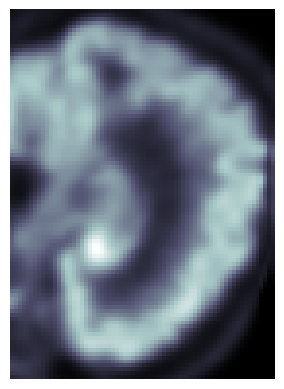

In [188]:
plt.imshow(image_data[10][50], cmap='bone')
plt.axis('off')
plt.show()

th e image data now have no Nans, i have filled in the nana by looking at pixels around the nan

In [189]:
from numpy.random import seed
seed(1)
# Set the random seed
tf.random.set_seed(42)

In [190]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data, train_sex, test_sex, train_labels, test_labels = train_test_split(image_data, sexes, ages, test_size=0.2, random_state=42)

### Baseline
the baseline will be the average of the ages

In [191]:
mean_age = np.mean(ages)

In [192]:
predictions = np.ones(len(test_labels))*mean_age


# Calculate different evaluation metrics
mse = mean_squared_error(test_labels, predictions)
mae = mean_absolute_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)

# Display the metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 20.140921074312082
Mean Absolute Error: 3.710084033613445
R-squared: -0.03521517409925745


### V1
model without sex, without transfer learning, ...

In [38]:
model = Sequential() # using sequential

# Add 3D Convolutional layers with MaxPooling
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(79, 95, 68, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', input_shape=(79, 95, 68, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


# Flatten the output and add Dense layers for age prediction
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))  # Use 'linear' activation for regression tasks

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 77, 93, 66, 64)    1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 38, 46, 33, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 36, 44, 31, 64)    110656    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 18, 22, 15, 64)   0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 380160)            0         
                                                                 
 dense (Dense)               (None, 32)                1

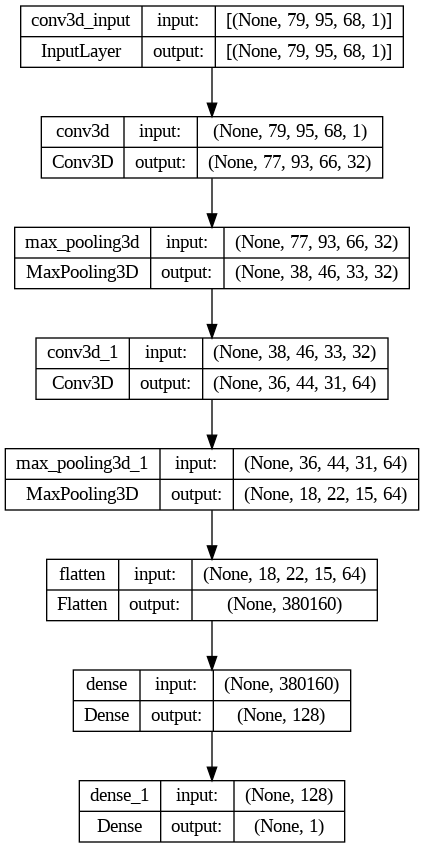

In [ ]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True) #vis of architecture


Lets train the model

Epoch 1/100
4/4 [==============================] - 6s 389ms/step - loss: 2808.0569 - val_loss: 836.0582
Epoch 2/100
4/4 [==============================] - 1s 306ms/step - loss: 528.5614 - val_loss: 177.6619
Epoch 3/100
4/4 [==============================] - 1s 306ms/step - loss: 257.0763 - val_loss: 197.1618
Epoch 4/100
4/4 [==============================] - 1s 307ms/step - loss: 154.7242 - val_loss: 194.0791
Epoch 5/100
4/4 [==============================] - 1s 304ms/step - loss: 125.4617 - val_loss: 114.1661
Epoch 6/100
4/4 [==============================] - 1s 305ms/step - loss: 73.1870 - val_loss: 65.5566
Epoch 7/100
4/4 [==============================] - 1s 304ms/step - loss: 52.6357 - val_loss: 30.6552
Epoch 8/100
4/4 [==============================] - 1s 309ms/step - loss: 46.3890 - val_loss: 24.8461
Epoch 9/100
4/4 [==============================] - 1s 308ms/step - loss: 35.4596 - val_loss: 16.8023
Epoch 10/100
4/4 [==============================] - 1s 311ms/step - loss: 27.653

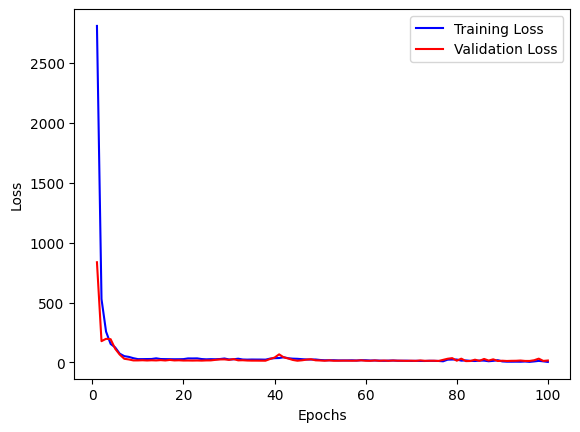

In [39]:
# Run model.fit() and store the training history
history = model.fit(train_data, train_labels, epochs=100, batch_size=16, validation_split=0.2)

# Access the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Access the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Zoom in on the graph

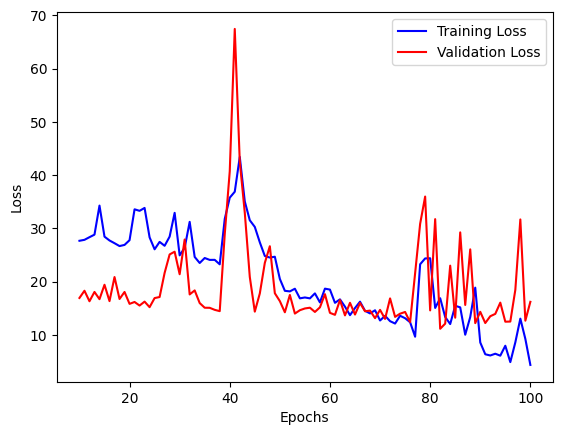

In [40]:
epochs = range(10, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss[9:], 'b', label='Training Loss')
plt.plot(epochs, val_loss[9:], 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We see that the model is unstable and over fits for high epochs

In [42]:
# Evaluate the model on the test set
test_loss = model.evaluate(test_data, test_labels)
print("Test Loss:", test_loss)


1/1 [==============================] - 0s 200ms/step - loss: 19.4910
Test Loss: 19.491012573242188


In [45]:
predictions = model.predict(test_data)
# Calculate different evaluation metrics
mse = mean_squared_error(test_labels, predictions)
mae = mean_absolute_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)

# Display the metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

1/1 [==============================] - 0s 52ms/step
Mean Squared Error: 19.491012773360126
Mean Absolute Error: 3.2245236351376487
R-squared: -0.0018107963929856474


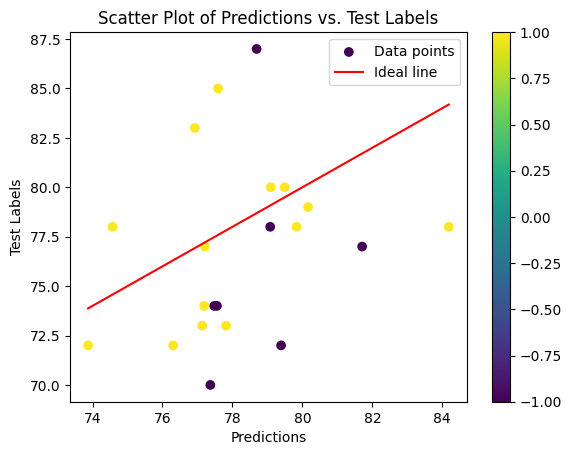

In [ ]:
# Assuming you have your data for predictions, test_labels, and sex_train
# Create a scatter plot
plt.scatter(predictions, test_labels, c=test_sex, cmap='viridis', label='Data points')
plt.plot([min(predictions), max(predictions)], [min(predictions), max(predictions)], c='red', label='Ideal line')

# Add labels and title
plt.xlabel('Predictions')
plt.ylabel('Test Labels')
plt.title('Scatter Plot of Predictions vs. Test Labels')

# Add a legend
plt.legend()

# Show the plot
plt.colorbar()  # Add a colorbar to show the mapping of colors to sex_train values
plt.show()



In [27]:
del model
import gc
gc.collect()
tf.keras.backend.clear_session()

We see more males (1) above the line and females below, perhaps adding sex as a feature can improve the model? This will be done later

### V2
Adding early stopping to prevent overfitting

In [28]:
model = Sequential() # using sequential

# Add 3D Convolutional layers with MaxPooling
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(79, 95, 68, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten the output and add Dense layers for age prediction
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))  # Use 'linear' activation for regression tasks

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

Lets train the model with early stopping

In [29]:
callbacks = [EarlyStopping(monitor='val_loss', patience=100),
             ModelCheckpoint(filepath='basic_model.h5', monitor='val_loss', save_best_only=True)]

Epoch 1/200
4/4 [==============================] - 6s 877ms/step - loss: 1815.9822 - val_loss: 17.6195
Epoch 2/200
4/4 [==============================] - 1s 308ms/step - loss: 65.1401 - val_loss: 85.7217
Epoch 3/200
4/4 [==============================] - 1s 307ms/step - loss: 76.2787 - val_loss: 24.1464
Epoch 4/200
4/4 [==============================] - 1s 306ms/step - loss: 45.3227 - val_loss: 34.7534
Epoch 5/200
4/4 [==============================] - 1s 309ms/step - loss: 41.3167 - val_loss: 18.3467
Epoch 6/200
4/4 [==============================] - 1s 305ms/step - loss: 33.2154 - val_loss: 23.7530
Epoch 7/200
4/4 [==============================] - 1s 306ms/step - loss: 31.8532 - val_loss: 33.6271
Epoch 8/200
4/4 [==============================] - 1s 310ms/step - loss: 42.9918 - val_loss: 24.5418
Epoch 9/200
4/4 [==============================] - 1s 308ms/step - loss: 32.6458 - val_loss: 18.5745
Epoch 10/200
4/4 [==============================] - 1s 306ms/step - loss: 31.1114 - val_l

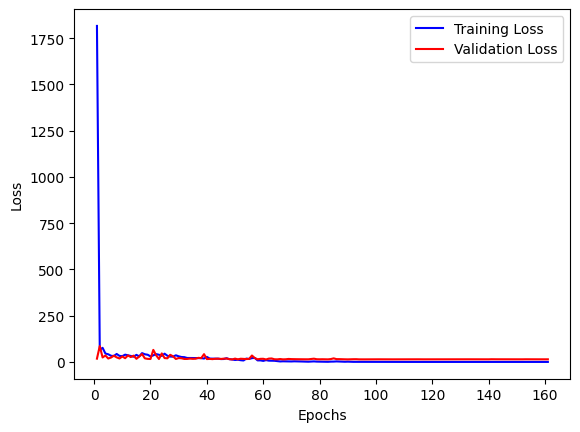

In [30]:
# Run model.fit() and store the training history
history = model.fit(train_data, train_labels, epochs=200, batch_size=16, validation_split=0.2, callbacks = callbacks)

# Access the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Access the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Zoom in on the graph

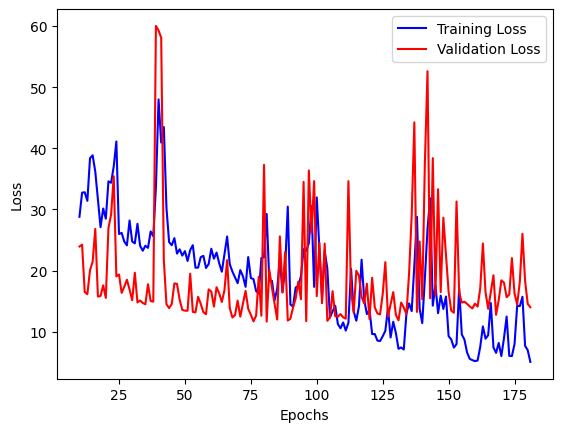

In [ ]:
epochs = range(10, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss[9:], 'b', label='Training Loss')
plt.plot(epochs, val_loss[9:], 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We see that the model begins to over fit for high epochs and this is where the early stopping stops the models from training

In [ ]:
from keras.models import load_model
saved_model = load_model('basic_model.h5')
train_acc = saved_model.evaluate(train_data, train_labels, verbose=0)
test_acc = saved_model.evaluate(test_data, test_labels, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 14.208, Test: 17.417


In [ ]:
# Evaluate the model on the test set
test_loss = saved_model.evaluate(test_data, test_labels)
print("Test Loss:", test_loss)


1/1 [==============================] - 0s 152ms/step - loss: 17.4171
Test Loss: 17.417123794555664


In [ ]:
predictions = saved_model.predict(test_data)
# Calculate different evaluation metrics
mse = mean_squared_error(test_labels, predictions)
mae = mean_absolute_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)

# Display the metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

1/1 [==============================] - 0s 93ms/step
Mean Squared Error: 17.417124618923047
Mean Absolute Error: 3.4120225452241444
R-squared: 0.10478415420220688


The model has improved a very small amount

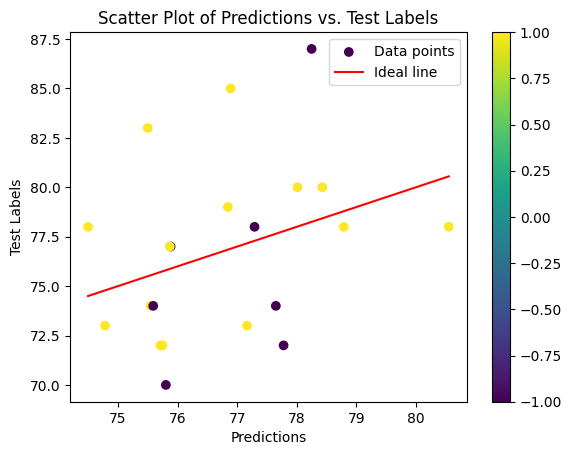

In [ ]:
# Assuming you have your data for predictions, test_labels, and sex_train
# Create a scatter plot
plt.scatter(predictions, test_labels, c=test_sex, cmap='viridis', label='Data points')
plt.plot([min(predictions), max(predictions)], [min(predictions), max(predictions)], c='red', label='Ideal line')

# Add labels and title
plt.xlabel('Predictions')
plt.ylabel('Test Labels')
plt.title('Scatter Plot of Predictions vs. Test Labels')

# Add a legend
plt.legend()

# Show the plot
plt.colorbar()  # Add a colorbar to show the mapping of colors to sex_train values
plt.show()



Somehow sex is now more scattered, we can still try adding it as a feature to see if it helps


###  V3
Adding sex as a feature with early stopping

In [57]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, concatenate

# Define the input layer for the 3D Convolutional network
input_img = Input(shape=(79, 95, 68, 1))

# Apply 3D Convolutional layers with MaxPooling using the Functional API
x = Conv3D(32, kernel_size=(3, 3, 3), activation='relu')(input_img)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = Conv3D(64, kernel_size=(3, 3, 3), activation='relu')(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)

# Flatten the output and add Dense layers for age prediction
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output_img = Dense(1, activation='linear')(x)

# Define the input layer for the extra feature
input_extra = Input(shape=(1,))

# Concatenate the output of the Convolutional network with the extra feature
merged = concatenate([output_img, input_extra])

# Add Dense layers for further prediction
merged = Dense(4, activation='relu')(merged)
output = Dense(1, activation='linear')(merged)  # Use 'linear' activation for regression tasks

# Define the model with both inputs and the final output
model = Model(inputs=[input_img, input_extra], outputs=output)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')


In [74]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, concatenate

# Define the input layer for the 3D Convolutional network
input_img = Input(shape=(79, 95, 68, 1))

# Apply 3D Convolutional layers with MaxPooling using the Functional API
x = Conv3D(32, kernel_size=(3, 3, 3), activation='relu')(input_img)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = Conv3D(64, kernel_size=(3, 3, 3), activation='relu')(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)

# Flatten the output and add Dense layers for age prediction
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output_img = Dense(16, activation='linear')(x)

# Define the input layer for the extra feature
input_extra = Input(shape=(1,))

# Concatenate the output of the Convolutional network with the extra feature
merged = concatenate([output_img, input_extra])

# Add Dense layers for further prediction
merged = Dense(8, activation='relu')(merged)
output = Dense(1, activation='linear')(merged)  # Use 'linear' activation for regression tasks

# Define the model with both inputs and the final output
model = Model(inputs=[input_img, input_extra], outputs=output)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')


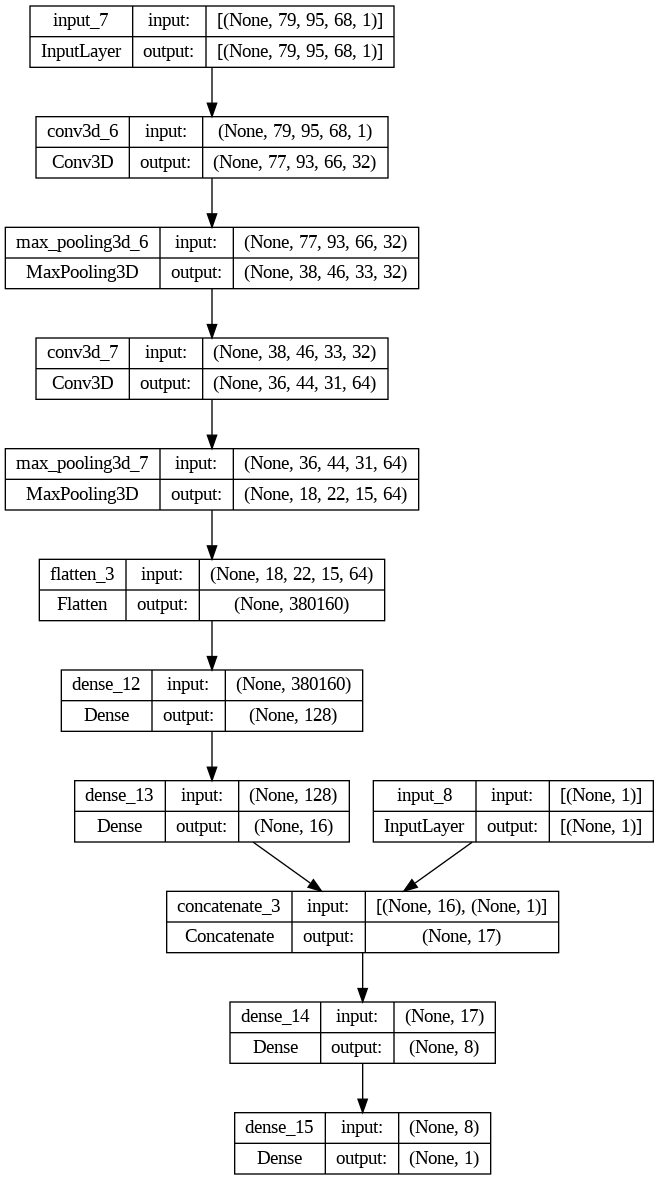

In [75]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True) #vis of architecture

In [76]:
callbacks = [EarlyStopping(monitor='val_loss', patience=100),
             ModelCheckpoint(filepath='basic_sex_model.h5', monitor='val_loss', save_best_only=True)]

Epoch 1/100
4/4 [==============================] - 5s 1s/step - loss: 6828.8145 - val_loss: 4467.8594
Epoch 2/100
4/4 [==============================] - 3s 951ms/step - loss: 4400.7495 - val_loss: 3781.1741
Epoch 3/100
4/4 [==============================] - 4s 1s/step - loss: 2814.3694 - val_loss: 778.1365
Epoch 4/100
4/4 [==============================] - 1s 305ms/step - loss: 420.5643 - val_loss: 1214.3479
Epoch 5/100
4/4 [==============================] - 4s 1s/step - loss: 869.3428 - val_loss: 41.4731
Epoch 6/100
4/4 [==============================] - 1s 306ms/step - loss: 147.5361 - val_loss: 412.9963
Epoch 7/100
4/4 [==============================] - 1s 307ms/step - loss: 404.7803 - val_loss: 168.4288
Epoch 8/100
4/4 [==============================] - 1s 308ms/step - loss: 75.8432 - val_loss: 111.7802
Epoch 9/100
4/4 [==============================] - 1s 305ms/step - loss: 161.4918 - val_loss: 101.1150
Epoch 10/100
4/4 [==============================] - 1s 305ms/step - loss: 51.0

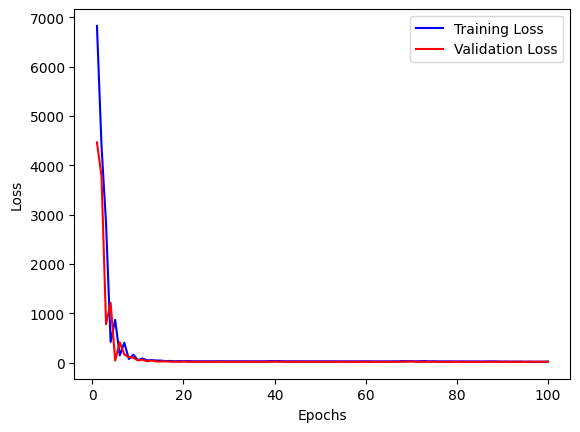

In [77]:
# Run model.fit() and store the training history
history = model.fit([train_data, train_sex], train_labels, epochs=100, batch_size=16, validation_split=0.2, callbacks = callbacks)

# Access the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Access the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

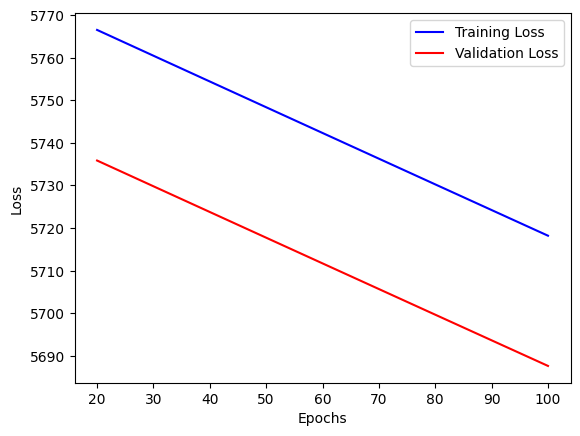

In [68]:
epochs = range(20, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss[19:], 'b', label='Training Loss')
plt.plot(epochs, val_loss[19:], 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [78]:
saved_model = load_model('basic_sex_model.h5')
train_acc = saved_model.evaluate([train_data, train_sex], train_labels, verbose=0)
test_acc = saved_model.evaluate([test_data, test_sex], test_labels, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 20.991, Test: 18.977


In [79]:
predictions = saved_model.predict([test_data, test_sex])
# Calculate different evaluation metrics
mse = mean_squared_error(test_labels, predictions)
mae = mean_absolute_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)

# Display the metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

1/1 [==============================] - 0s 98ms/step
Mean Squared Error: 18.97686843771953
Mean Absolute Error: 3.5381048293340776
R-squared: 0.024615503375953973


The model has improved slightly

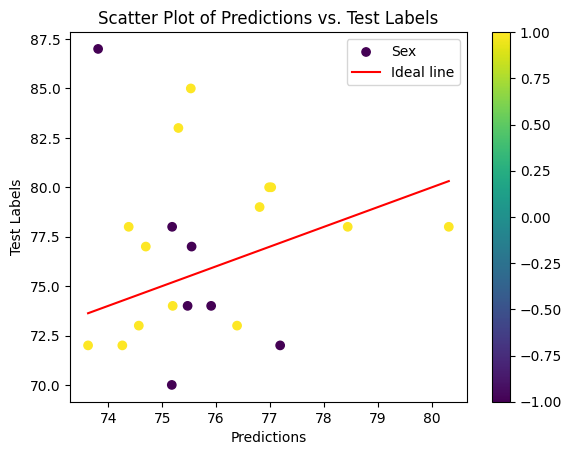

In [63]:
# Assuming you have your data for predictions, test_labels, and sex_train
# Create a scatter plot
plt.scatter(predictions, test_labels, c=test_sex, cmap='viridis', label='Sex')
plt.plot([min(predictions), max(predictions)], [min(predictions), max(predictions)], c='red', label='Ideal line')

# Add labels and title
plt.xlabel('Predictions')
plt.ylabel('Test Labels')
plt.title('Scatter Plot of Predictions vs. Test Labels')

# Add a legend
plt.legend()

# Show the plot
plt.colorbar()  # Add a colorbar to show the mapping of colors to sex_train values
plt.show()



We see that after adding sex the poins are more equally spread however the model still does not perform too well, perhaps tuning the model will help

### V4
Tuning the model with bayesian optimisation, this is more effecient than grid and random search (typically)

In [14]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.9 MB/s eta 0:00:00


In [80]:
import time
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from keras.optimizers import Adam
import traceback
import gc

def create_model(kernel_size, num_layers, neurons1, neurons2, neurons3, learning_rate, dilation_rate, pool_size, dropout = 0.2, activation = 'relu', strides=(1,1,1), padding='same'):
  # Define the input layer for the 3D Convolutional network
  input_img = Input(shape=(79, 95, 68, 1))
  x = Conv3D(neurons1, kernel_size=kernel_size, activation=activation)(input_img)
  x = MaxPooling3D(pool_size=pool_size)(x)
  x = Dropout(dropout)(x)
  # Apply 3D Convolutional layers with MaxPooling using the Functional API
  for i in range(num_layers):
    try:
      x = Conv3D(neurons1, kernel_size=kernel_size, activation=activation)(x)
      x = MaxPooling3D(pool_size=pool_size)(x)
      x = Dropout(dropout)(x)
    except:
      traceback.print_exc()
      return(999)
  # Flatten the output and add Dense layers for age prediction
  x = Flatten()(x)
  x = Dense(neurons2, activation=activation)(x)
  output_img = Dense(16, activation='relu')(x)
  # Define the input layer for the extra feature
  input_extra = Input(shape=(1,))
  # Concatenate the output of the Convolutional network with the extra feature
  merged = concatenate([output_img, input_extra])
  # Add Dense layers for further prediction
  merged = Dense(neurons3, activation=activation)(merged)
  output = Dense(1, activation='linear')(merged)  # Use 'linear' activation for regression tasks
  # Define the model with both inputs and the final output
  model = Model(inputs=[input_img, input_extra], outputs=output)
  optimizer = Adam(learning_rate=learning_rate)
  # Compile the model
  model.compile(loss='mean_squared_error', optimizer=optimizer)
  return model




def objective(trial):
    callbacks = [EarlyStopping(monitor='val_loss', patience=40),
             ModelCheckpoint(filepath='bayesian_model.h5', monitor='val_loss', save_best_only=True)]
    """return the mse"""
    num_layers = trial.suggest_int('num_layers', low = 1, high = 2, step = 1)
    neurons1 = trial.suggest_int('neurons1', low = 2, high = 16, step = 4)
    neurons2 = trial.suggest_int('neurons2', low = 2, high = 16, step = 4)
    neurons3 = trial.suggest_int('neurons3', low = 2, high = 16, step = 4)
    batch_size = trial.suggest_int('batch_size', low = 8, high = 32, step = 8)
    learning_rate = trial.suggest_float('learning_rate', low = 0.00001, high = 0.01, step = 0.0005)

    kernel_size = trial.suggest_int('kernel_size', low = 3, high =5, step =1)
    dilation_rate = trial.suggest_int('dilation_rate', low = 1, high =3, step =1)
    pool_size = trial.suggest_int('pool_size', low = 1, high =2, step =1)

    # random forest classifier object
    model = create_model(kernel_size = (kernel_size,kernel_size,kernel_size), num_layers = num_layers, neurons1 = neurons1, neurons2 = neurons2, neurons3 = neurons3, learning_rate = learning_rate, dilation_rate=(dilation_rate,dilation_rate,dilation_rate), pool_size=(pool_size,pool_size,pool_size))
    print(model.summary())
    try:
      model.fit([train_data, train_sex], train_labels, epochs=100, batch_size= batch_size, validation_split=0.2, callbacks = callbacks)
    except:
      traceback.print_exc()
      del model
      gc.collect()
      tf.keras.backend.clear_session()
      return(50)
      #res = model.evaluate([test_data, test_sex], test_labels, verbose=0)
    try:
      saved_model = load_model('bayesian_model.h5')
      res = saved_model.evaluate([test_data, test_sex], test_labels, verbose=0)
      del model
      del saved_model
      gc.collect()
      tf.keras.backend.clear_session()
      #!rm bayesian_model.h5
      return(res)
    except:
      traceback.print_exc()
      print('callback error')
      del model
      gc.collect()
      tf.keras.backend.clear_session()
      return(50)


# create a study (aim to maximize score)
study = optuna.create_study(sampler=TPESampler(), direction='minimize')

# perform hyperparamter tuning (while timing the process)
time_start = time.time()
study.optimize(objective, n_trials=50, gc_after_trial=True)
time_bayesian = time.time() - time_start

columns = ['Number of iterations', 'Iteration Number of Optimal Hyperparamters', 'Score', 'Time Elapsed (s)']

# store result in a data frame
values_bayesian = [100, study.best_trial.number, study.best_trial.value, time_bayesian]
results_bayesian = pd.DataFrame([values_bayesian], columns = columns)

[I 2023-08-16 16:13:28,564] A new study created in memory with name: no-name-25b1a708-9b47-46d1-9035-898c738d74c3


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d_8 (Conv3D)              (None, 77, 93, 66,   280         ['input_9[0][0]']                
                                10)                                                               
                                                                                                  
 max_pooling3d_8 (MaxPooling3D)  (None, 77, 93, 66,   0          ['conv3d_8[0][0]']               
                                10)                                                         

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:700: UserWarning:

The distribution is specified by [2, 16] and step=4, but the range is not divisible by `step`. It will be replaced by [2, 14].

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [1e-05, 0.01] and step=0.0005, but the range is not divisible by `step`. It will be replaced by [1e-05, 0.00951].



None
Epoch 1/100
4/4 [==============================] - 3s 528ms/step - loss: 2884.8914 - val_loss: nan
Epoch 2/100
4/4 [==============================] - 2s 455ms/step - loss: 5028.7549 - val_loss: nan
Epoch 3/100
4/4 [==============================] - 2s 455ms/step - loss: 4802.5156 - val_loss: nan
Epoch 4/100
4/4 [==============================] - 2s 457ms/step - loss: 4615.0186 - val_loss: nan
Epoch 5/100
4/4 [==============================] - 2s 457ms/step - loss: 2613.3508 - val_loss: nan
Epoch 6/100
4/4 [==============================] - 2s 460ms/step - loss: 969.4016 - val_loss: nan
Epoch 7/100
4/4 [==============================] - 2s 458ms/step - loss: 472.6724 - val_loss: nan
Epoch 8/100
4/4 [==============================] - 2s 456ms/step - loss: 794.5766 - val_loss: nan
Epoch 9/100
4/4 [==============================] - 2s 459ms/step - loss: 200.3567 - val_loss: nan
Epoch 10/100
4/4 [==============================] - 2s 460ms/step - loss: 333.0480 - val_loss: nan
Epoch 11/

[I 2023-08-16 16:14:42,615] Trial 0 finished with value: 18.51470184326172 and parameters: {'num_layers': 1, 'neurons1': 10, 'neurons2': 14, 'neurons3': 6, 'batch_size': 16, 'learning_rate': 0.00601, 'kernel_size': 3, 'dilation_rate': 2, 'pool_size': 1}. Best is trial 0 with value: 18.51470184326172.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   1764        ['input_1[0][0]']                
                                14)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 75, 91, 64,   0           ['conv3d[0][0]']                 
                                14)                                                           

[I 2023-08-16 16:18:33,260] Trial 1 finished with value: 18.51470184326172 and parameters: {'num_layers': 2, 'neurons1': 14, 'neurons2': 2, 'neurons3': 6, 'batch_size': 16, 'learning_rate': 0.00301, 'kernel_size': 5, 'dilation_rate': 3, 'pool_size': 1}. Best is trial 0 with value: 18.51470184326172.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   252         ['input_1[0][0]']                
                                2)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 37, 45, 32,   0           ['conv3d[0][0]']                 
                                2)                                                            

[I 2023-08-16 16:19:08,469] Trial 2 finished with value: 5594.69091796875 and parameters: {'num_layers': 1, 'neurons1': 2, 'neurons2': 10, 'neurons3': 2, 'batch_size': 16, 'learning_rate': 0.005509999999999999, 'kernel_size': 5, 'dilation_rate': 1, 'pool_size': 2}. Best is trial 0 with value: 18.51470184326172.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 76, 92, 65,   390         ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 38, 46, 32,   0           ['conv3d[0][0]']                 
                                6)                                                            

[I 2023-08-16 16:20:00,616] Trial 3 finished with value: 217.15377807617188 and parameters: {'num_layers': 2, 'neurons1': 6, 'neurons2': 14, 'neurons3': 10, 'batch_size': 8, 'learning_rate': 0.00301, 'kernel_size': 4, 'dilation_rate': 1, 'pool_size': 2}. Best is trial 0 with value: 18.51470184326172.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 77, 93, 66,   56          ['input_1[0][0]']                
                                2)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 38, 46, 33,   0           ['conv3d[0][0]']                 
                                2)                                                            

[I 2023-08-16 16:20:23,046] Trial 4 finished with value: 42.931060791015625 and parameters: {'num_layers': 1, 'neurons1': 2, 'neurons2': 6, 'neurons3': 14, 'batch_size': 32, 'learning_rate': 0.00801, 'kernel_size': 3, 'dilation_rate': 1, 'pool_size': 2}. Best is trial 0 with value: 18.51470184326172.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   1764        ['input_1[0][0]']                
                                14)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 37, 45, 32,   0           ['conv3d[0][0]']                 
                                14)                                                           

[I 2023-08-16 16:21:57,691] Trial 5 finished with value: 21.36074447631836 and parameters: {'num_layers': 1, 'neurons1': 14, 'neurons2': 2, 'neurons3': 14, 'batch_size': 16, 'learning_rate': 0.007509999999999999, 'kernel_size': 5, 'dilation_rate': 1, 'pool_size': 2}. Best is trial 0 with value: 18.51470184326172.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   252         ['input_1[0][0]']                
                                2)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 75, 91, 64,   0           ['conv3d[0][0]']                 
                                2)                                                            

[I 2023-08-16 16:22:23,912] Trial 6 finished with value: 21.36074447631836 and parameters: {'num_layers': 1, 'neurons1': 2, 'neurons2': 10, 'neurons3': 6, 'batch_size': 24, 'learning_rate': 0.007509999999999999, 'kernel_size': 5, 'dilation_rate': 3, 'pool_size': 1}. Best is trial 0 with value: 18.51470184326172.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 76, 92, 65,   650         ['input_1[0][0]']                
                                10)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 38, 46, 32,   0           ['conv3d[0][0]']                 
                                10)                                                           

[I 2023-08-16 16:22:52,914] Trial 7 finished with value: 22.109756469726562 and parameters: {'num_layers': 1, 'neurons1': 10, 'neurons2': 2, 'neurons3': 2, 'batch_size': 32, 'learning_rate': 0.00401, 'kernel_size': 4, 'dilation_rate': 1, 'pool_size': 2}. Best is trial 0 with value: 18.51470184326172.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 77, 93, 66,   168         ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 38, 46, 33,   0           ['conv3d[0][0]']                 
                                6)                                                            

[I 2023-08-16 16:23:40,339] Trial 8 finished with value: 20.55018424987793 and parameters: {'num_layers': 1, 'neurons1': 6, 'neurons2': 2, 'neurons3': 14, 'batch_size': 16, 'learning_rate': 0.00451, 'kernel_size': 3, 'dilation_rate': 3, 'pool_size': 2}. Best is trial 0 with value: 18.51470184326172.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 76, 92, 65,   650         ['input_1[0][0]']                
                                10)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 38, 46, 32,   0           ['conv3d[0][0]']                 
                                10)                                                           

[I 2023-08-16 16:24:21,428] Trial 9 finished with value: 31.434701919555664 and parameters: {'num_layers': 1, 'neurons1': 10, 'neurons2': 6, 'neurons3': 14, 'batch_size': 16, 'learning_rate': 0.00101, 'kernel_size': 4, 'dilation_rate': 3, 'pool_size': 2}. Best is trial 0 with value: 18.51470184326172.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 77, 93, 66,   280         ['input_1[0][0]']                
                                10)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 77, 93, 66,   0           ['conv3d[0][0]']                 
                                10)                                                           

[I 2023-08-16 16:26:45,383] Trial 10 finished with value: 31.434701919555664 and parameters: {'num_layers': 2, 'neurons1': 10, 'neurons2': 14, 'neurons3': 10, 'batch_size': 8, 'learning_rate': 0.00901, 'kernel_size': 3, 'dilation_rate': 2, 'pool_size': 1}. Best is trial 0 with value: 18.51470184326172.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 76, 92, 65,   910         ['input_1[0][0]']                
                                14)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 76, 92, 65,   0           ['conv3d[0][0]']                 
                                14)                                                           

[I 2023-08-16 16:29:41,838] Trial 11 finished with value: 31.434701919555664 and parameters: {'num_layers': 2, 'neurons1': 14, 'neurons2': 10, 'neurons3': 6, 'batch_size': 24, 'learning_rate': 0.00151, 'kernel_size': 4, 'dilation_rate': 2, 'pool_size': 1}. Best is trial 0 with value: 18.51470184326172.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   1764        ['input_1[0][0]']                
                                14)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 75, 91, 64,   0           ['conv3d[0][0]']                 
                                14)                                                           

[I 2023-08-16 16:33:43,327] Trial 12 finished with value: 31.434701919555664 and parameters: {'num_layers': 2, 'neurons1': 14, 'neurons2': 6, 'neurons3': 6, 'batch_size': 8, 'learning_rate': 0.00601, 'kernel_size': 5, 'dilation_rate': 2, 'pool_size': 1}. Best is trial 0 with value: 18.51470184326172.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 77, 93, 66,   392         ['input_1[0][0]']                
                                14)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 77, 93, 66,   0           ['conv3d[0][0]']                 
                                14)                                                           

[I 2023-08-16 16:37:07,342] Trial 13 finished with value: 31.434701919555664 and parameters: {'num_layers': 2, 'neurons1': 14, 'neurons2': 14, 'neurons3': 6, 'batch_size': 24, 'learning_rate': 0.00251, 'kernel_size': 3, 'dilation_rate': 3, 'pool_size': 1}. Best is trial 0 with value: 18.51470184326172.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 76, 92, 65,   650         ['input_1[0][0]']                
                                10)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 76, 92, 65,   0           ['conv3d[0][0]']                 
                                10)                                                           

[I 2023-08-16 16:39:20,542] Trial 14 finished with value: 31.434701919555664 and parameters: {'num_layers': 2, 'neurons1': 10, 'neurons2': 6, 'neurons3': 2, 'batch_size': 16, 'learning_rate': 1e-05, 'kernel_size': 4, 'dilation_rate': 2, 'pool_size': 1}. Best is trial 0 with value: 18.51470184326172.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   756         ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 75, 91, 64,   0           ['conv3d[0][0]']                 
                                6)                                                            

[I 2023-08-16 16:41:44,568] Trial 15 finished with value: 31.434701919555664 and parameters: {'num_layers': 2, 'neurons1': 6, 'neurons2': 10, 'neurons3': 10, 'batch_size': 24, 'learning_rate': 0.00601, 'kernel_size': 5, 'dilation_rate': 2, 'pool_size': 1}. Best is trial 0 with value: 18.51470184326172.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 77, 93, 66,   392         ['input_1[0][0]']                
                                14)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 77, 93, 66,   0           ['conv3d[0][0]']                 
                                14)                                                           

[I 2023-08-16 16:45:08,591] Trial 16 finished with value: 31.434701919555664 and parameters: {'num_layers': 2, 'neurons1': 14, 'neurons2': 2, 'neurons3': 6, 'batch_size': 8, 'learning_rate': 0.00351, 'kernel_size': 3, 'dilation_rate': 3, 'pool_size': 1}. Best is trial 0 with value: 18.51470184326172.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 76, 92, 65,   650         ['input_1[0][0]']                
                                10)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 76, 92, 65,   0           ['conv3d[0][0]']                 
                                10)                                                           

[I 2023-08-16 16:46:32,606] Trial 17 finished with value: 31.434701919555664 and parameters: {'num_layers': 1, 'neurons1': 10, 'neurons2': 14, 'neurons3': 10, 'batch_size': 16, 'learning_rate': 0.00501, 'kernel_size': 4, 'dilation_rate': 2, 'pool_size': 1}. Best is trial 0 with value: 18.51470184326172.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 76, 92, 65,   910         ['input_1[0][0]']                
                                14)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 76, 92, 65,   0           ['conv3d[0][0]']                 
                                14)                                                           

Traceback (most recent call last):
  File "<ipython-input-80-16f526cf7a2c>", line 64, in objective
    model.fit([train_data, train_sex], train_labels, epochs=100, batch_size= batch_size, validation_split=0.2, callbacks = callbacks)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1685, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 894, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 959, in _call
    return self._no_var

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   1260        ['input_1[0][0]']                
                                10)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 75, 91, 64,   0           ['conv3d[0][0]']                 
                                10)                                                           

Traceback (most recent call last):
  File "<ipython-input-80-16f526cf7a2c>", line 64, in objective
    model.fit([train_data, train_sex], train_labels, epochs=100, batch_size= batch_size, validation_split=0.2, callbacks = callbacks)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1685, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 894, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 942, in _call
    self._initialize(ar

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 77, 93, 66,   168         ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 77, 93, 66,   0           ['conv3d[0][0]']                 
                                6)                                                            

Traceback (most recent call last):
  File "<ipython-input-80-16f526cf7a2c>", line 64, in objective
    model.fit([train_data, train_sex], train_labels, epochs=100, batch_size= batch_size, validation_split=0.2, callbacks = callbacks)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1691, in fit
    callbacks.on_train_batch_end(end_step, logs)
  File "/usr/local/lib/python3.10/dist-packages/keras/callbacks.py", line 475, in on_train_batch_end
    self._call_batch_hook(ModeKeys.TRAIN, "end", batch, logs=logs)
  File "/usr/local/lib/python3.10/dist-packages/keras/callbacks.py", line 322, in _call_batch_hook
    self._call_batch_end_hook(mode, batch, logs)
  File "/usr/local/lib/python3.10/dist-packages/keras/callbacks.py", line 345, in _call_batch_end_hook
    self._call_batch_hook_helper(hook_name, batch, logs)
  File "/us

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 77, 93, 66,   168         ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 38, 46, 33,   0           ['conv3d[0][0]']                 
                                6)                                                            

Traceback (most recent call last):
  File "<ipython-input-80-16f526cf7a2c>", line 64, in objective
    model.fit([train_data, train_sex], train_labels, epochs=100, batch_size= batch_size, validation_split=0.2, callbacks = callbacks)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1691, in fit
    callbacks.on_train_batch_end(end_step, logs)
  File "/usr/local/lib/python3.10/dist-packages/keras/callbacks.py", line 475, in on_train_batch_end
    self._call_batch_hook(ModeKeys.TRAIN, "end", batch, logs=logs)
  File "/usr/local/lib/python3.10/dist-packages/keras/callbacks.py", line 322, in _call_batch_hook
    self._call_batch_end_hook(mode, batch, logs)
  File "/usr/local/lib/python3.10/dist-packages/keras/callbacks.py", line 345, in _call_batch_end_hook
    self._call_batch_hook_helper(hook_name, batch, logs)
  File "/us

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 77, 93, 66,   168         ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 38, 46, 33,   0           ['conv3d[0][0]']                 
                                6)                                                            

Traceback (most recent call last):
  File "<ipython-input-80-16f526cf7a2c>", line 64, in objective
    model.fit([train_data, train_sex], train_labels, epochs=100, batch_size= batch_size, validation_split=0.2, callbacks = callbacks)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1729, in fit
    val_logs = self.evaluate(
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2072, in evaluate
    tmp_logs = self.test_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/poly

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 77, 93, 66,   168         ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 77, 93, 66,   0           ['conv3d[0][0]']                 
                                6)                                                            

Traceback (most recent call last):
  File "<ipython-input-80-16f526cf7a2c>", line 64, in objective
    model.fit([train_data, train_sex], train_labels, epochs=100, batch_size= batch_size, validation_split=0.2, callbacks = callbacks)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1691, in fit
    callbacks.on_train_batch_end(end_step, logs)
  File "/usr/local/lib/python3.10/dist-packages/keras/callbacks.py", line 475, in on_train_batch_end
    self._call_batch_hook(ModeKeys.TRAIN, "end", batch, logs=logs)
  File "/usr/local/lib/python3.10/dist-packages/keras/callbacks.py", line 322, in _call_batch_hook
    self._call_batch_end_hook(mode, batch, logs)
  File "/usr/local/lib/python3.10/dist-packages/keras/callbacks.py", line 345, in _call_batch_end_hook
    self._call_batch_hook_helper(hook_name, batch, logs)
  File "/us

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 77, 93, 66,   280         ['input_1[0][0]']                
                                10)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 38, 46, 33,   0           ['conv3d[0][0]']                 
                                10)                                                           

Traceback (most recent call last):
  File "<ipython-input-80-16f526cf7a2c>", line 64, in objective
    model.fit([train_data, train_sex], train_labels, epochs=100, batch_size= batch_size, validation_split=0.2, callbacks = callbacks)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1685, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 894, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 926, in _call
    return self._no_var

KeyboardInterrupt: ignored

In [53]:
values = [study.trials[i].values[0] for i in range(len(study.trials))]
params = [study.trials[i].params for i in range(len(study.trials))]
columns = list(params[0].keys()) + ['val']
bayesian_results = pd.DataFrame(columns = columns)
bayesian_results['val'] = values
for param in list(params[0].keys()):
  param_list = [study[param] for study in params]
  bayesian_results[param] = param_list

In [54]:
bayesian_results

,num_layers,neurons1,neurons2,neurons3,batch_size,learning_rate,kernel_size,dilation_rate,pool_size,val
0,2,14,6,14,24,0.00801,3,3,1,19.508263
1,2,10,10,10,32,0.00951,3,1,2,35.831013
2,2,14,6,2,8,0.00451,4,2,2,43.963089
3,2,10,6,2,16,0.00951,4,3,1,43.963089
4,2,14,14,14,24,0.00751,3,1,1,43.963089
5,2,6,6,2,24,0.00451,4,1,2,19.973284
6,1,14,10,14,24,0.00401,4,3,1,19.973284
7,1,14,10,10,32,0.00101,5,1,2,18.514702
8,1,6,2,2,16,0.00051,4,3,1,18.514702
9,2,14,14,6,8,0.00901,4,3,1,18.514702


In [121]:
results_bayesian

,Number of iterations,Iteration Number of Optimal Hyperparamters,Score,Time Elapsed (s)
0,100,0,18.983723,1194.613355


In [55]:
optuna.visualization.plot_contour(study)

In [56]:
optuna.visualization.plot_param_importances(study)

Tuning the model seems to make no real improvement, therefore other approaches must be taken, transfer learning can help as we only have 100 images

### V5

In [81]:
pip install classification-models-3D

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 1.8 MB/s eta 0:00:00


In [84]:
pip install keras_applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.4 MB/s eta 0:00:00


In [193]:
from classification_models_3D.tfkeras import Classifiers

vgg19, preprocess_input = Classifiers.get('vgg19')
pretrained_model = vgg19(input_shape=(79, 95, 68, 3), weights='imagenet')

In [194]:
image_data.shape

(102, 79, 95, 68, 1)

ASthis cnn takes in rgb input we must duplicate each image twice so that the input shapes match

In [195]:
duplicated_data = np.repeat(image_data, 3, axis=-1)
print(duplicated_data.shape)

(102, 79, 95, 68, 3)


In [196]:
train_data, test_data, train_sex, test_sex, train_labels, test_labels = train_test_split(duplicated_data, sexes, ages, test_size=0.2, random_state=42)

In [205]:
model = Sequential()

for layer in pretrained_model.layers:
    model.add(layer)

# Freeze the weights of the pre-trained layers so they are not updated during training
for layer in model.layers:
    layer.trainable = False

# Flatten the output and add Dense layers for age prediction
"""model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(keras.Input(shape=(1,)))
model.add(Dense(1, activation='linear')) """ # Use 'linear' activation for regression tasks


# Flatten the output of the pre-trained model
x = Flatten()(model.output)

# Add Dense layers after concatenation
x = Dense(32, activation='relu')(x)

additional_input = Input(shape=(1,))

# Concatenate the flattened output with the new input
concatenated = concatenate([x, additional_input])
output = Dense(1, activation='linear')(concatenated)  # Use 'linear' activation for regression tasks

# Create the final model
model = Model(inputs=[pretrained_model.input, additional_input], outputs=output)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')







# Compile the model
#model.compile(loss='mean_squared_error', optimizer='adam')


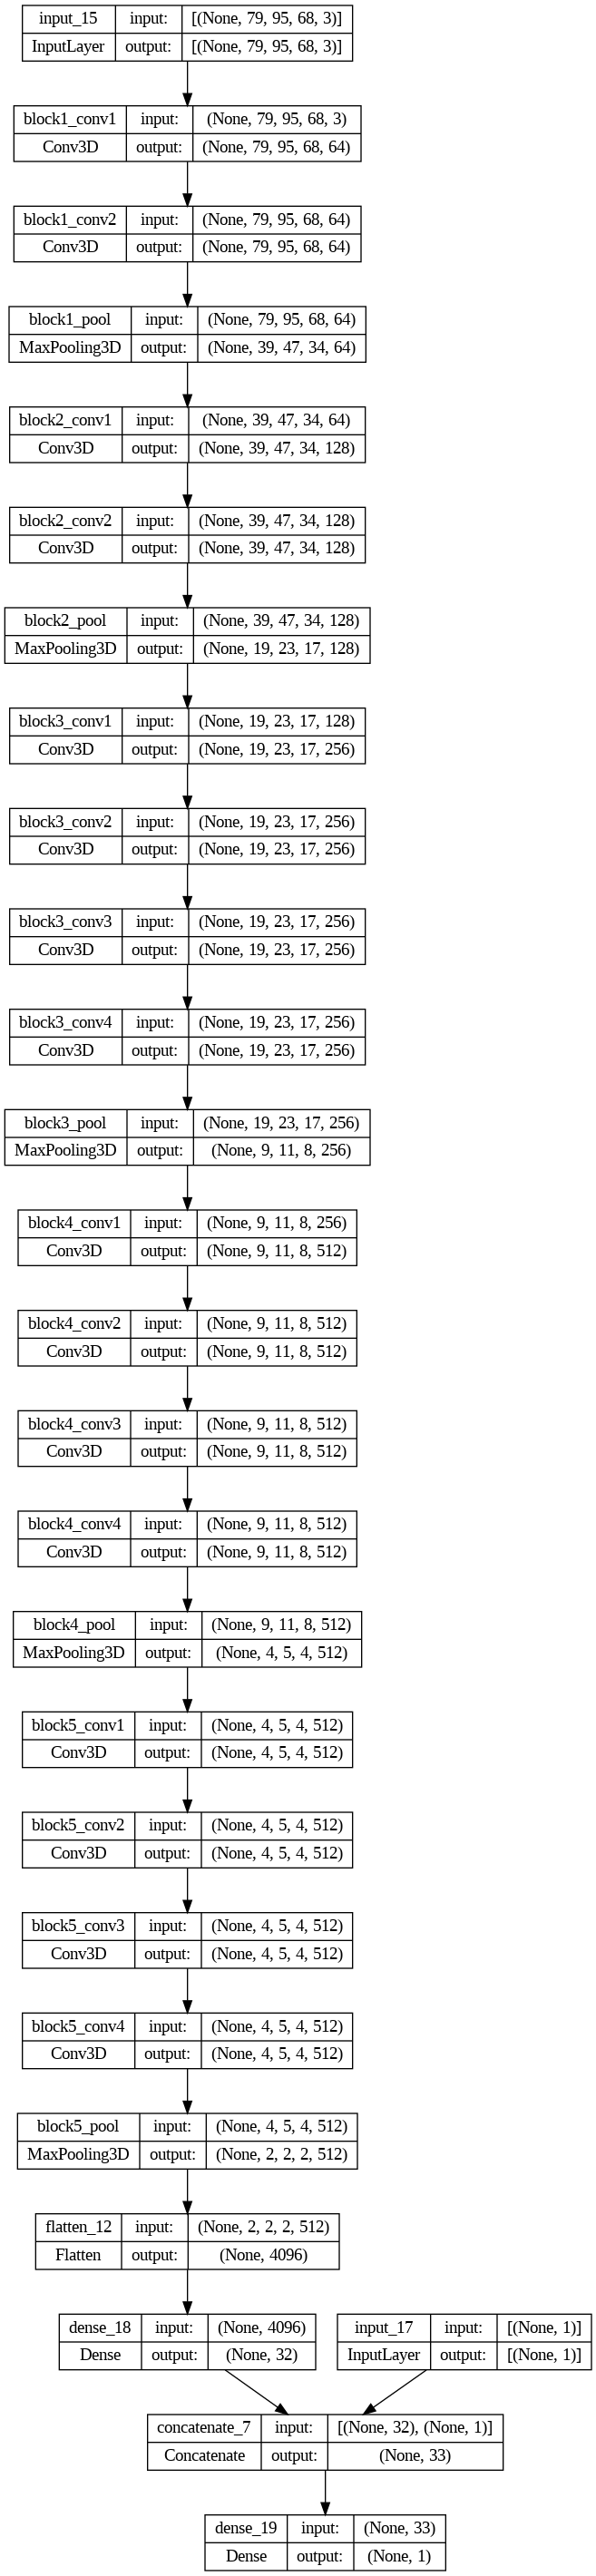

In [206]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True) #vis of architecture

Epoch 1/100
8/8 [==============================] - 11s 1s/step - loss: 5176.6167 - val_loss: 4463.7065
Epoch 2/100
8/8 [==============================] - 10s 1s/step - loss: 3982.0000 - val_loss: 3359.2883
Epoch 3/100
8/8 [==============================] - 10s 1s/step - loss: 2929.2737 - val_loss: 2389.3027
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 2025.8621 - val_loss: 1581.1060
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 1288.4336 - val_loss: 955.9838
Epoch 6/100
8/8 [==============================] - 9s 1s/step - loss: 750.2000 - val_loss: 510.8414
Epoch 7/100
8/8 [==============================] - 9s 1s/step - loss: 380.1790 - val_loss: 236.3372
Epoch 8/100
8/8 [==============================] - 9s 1s/step - loss: 167.3687 - val_loss: 92.6683
Epoch 9/100
8/8 [==============================] - 9s 1s/step - loss: 67.6073 - val_loss: 33.7261
Epoch 10/100
8/8 [==============================] - 9s 1s/step - loss: 36.2149 - val_loss: 

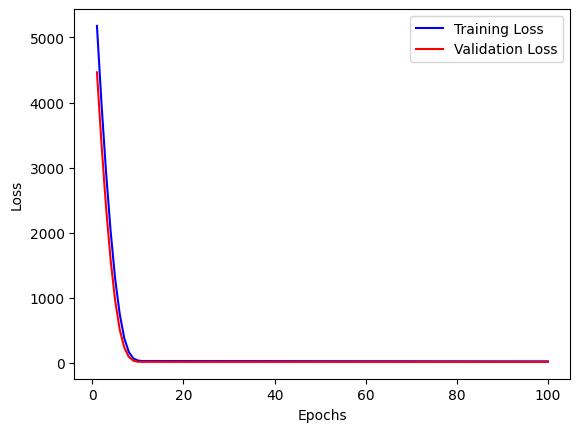

In [207]:
import matplotlib.pyplot as plt
callbacks = [EarlyStopping(monitor='val_loss', patience=40),
             ModelCheckpoint(filepath='TL_model.h5', monitor='val_loss', save_best_only=True)]
# Run model.fit() and store the training history
history = model.fit([train_data, train_sex], train_labels, epochs=100, batch_size=8, validation_split=0.2, callbacks=callbacks)

# Access the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Access the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [208]:
saved_model = load_model('TL_model.h5')
res = saved_model.evaluate([test_data, test_sex], test_labels, verbose=0)
print(res)

21.277732849121094


In [209]:
model.evaluate([test_data, test_sex], test_labels, verbose=0)

21.681306838989258

# The model does not outperform the baseline

 There are many things that can be changed:

- Adding sex as a feature
- Transfer Learning
- Dilated convolutions
- Random & Grid search to tune model
- Encorporating other metrics such as avg age
- Using 2d slices instead using GLOM for slice selection